# Advanced Pipeline Example

This notebook demonstrates more advanced use of SciKit-Learn pipelines; more sophisticated than my [basic pipeline example](SciKitPipeline.ipynb) and simpler than the [TDS example](https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738).

The classification task is to predict whether or not a movie is an action movie.  We are going to use regularized logistic regression for this task.  If we can effectively predict whether a movie is an action movie from its ratings (number of ratings and/or rating values), that is evidence that action movies have different patterns than other movies; maybe they are more popular, or (on average) higher- or lower-rated.

## Setup

As usual, we want to import things:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

And we'll import many things from SciKit-Learn:

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

And seed the RNG:

In [3]:
import seedbank
seedbank.initialize(20211028)

SeedSequence(
    entropy=20211028,
)

## Data Preparation

Let's first load the movie data:

In [4]:
movies = pd.read_csv('../data/hetrec2011-ml/movies.dat', sep='\t', encoding='latin1',
                     na_values='\\N')

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10197 non-null  int64  
 1   title                   10197 non-null  object 
 2   imdbID                  10197 non-null  int64  
 3   spanishTitle            10197 non-null  object 
 4   imdbPictureURL          10016 non-null  object 
 5   year                    10197 non-null  int64  
 6   rtID                    9886 non-null   object 
 7   rtAllCriticsRating      9967 non-null   float64
 8   rtAllCriticsNumReviews  9967 non-null   float64
 9   rtAllCriticsNumFresh    9967 non-null   float64
 10  rtAllCriticsNumRotten   9967 non-null   float64
 11  rtAllCriticsScore       9967 non-null   float64
 12  rtTopCriticsRating      9967 non-null   float64
 13  rtTopCriticsNumReviews  9967 non-null   float64
 14  rtTopCriticsNumFresh    9967 non-null 

And we'll need genres:

In [6]:
genres = pd.read_csv('../data/hetrec2011-ml/movie_genres.dat', sep='\t', encoding='latin1',
                     na_values='\\N')
genres

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
20804,65126,Comedy
20805,65126,Drama
20806,65130,Drama
20807,65130,Romance


We're going to get a list of action movie IDs and make our outcome column:

In [7]:
action_movies = genres.loc[genres['genre'] == 'Action', 'movieID']
movies['isAction'] = movies['id'].isin(action_movies)

Zero things out:

In [8]:
movies.loc[movies['rtAllCriticsRating'] == 0, 'rtAllCriticsRating'] = np.nan
movies.loc[movies['rtTopCriticsRating'] == 0, 'rtTopCriticsRating'] = np.nan
movies.loc[movies['rtAudienceRating'] == 0, 'rtAudienceRating'] = np.nan

Create our train/test split:

In [9]:
train, test = train_test_split(movies, test_size=0.25)

In [10]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

## Exploration

Now that we have training data, let's look at our class balance:

<AxesSubplot:xlabel='isAction', ylabel='count'>

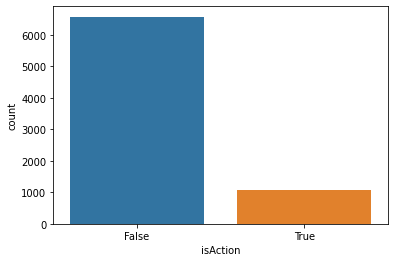

In [11]:
sns.countplot(x=train['isAction'])

Non-action is our majority class.  What is that fraction?

In [12]:
maj_frac = 1 - train['isAction'].mean()
maj_frac

0.8595527657905061

If our accuracy is **less** than 0.859, we aren't beating majority class.

Let's start to look at some possible correlations with our outcome variable.

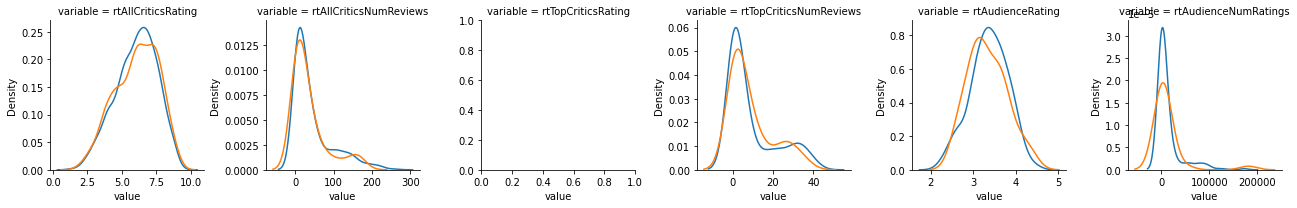

In [13]:
rate_cols = [
    'rtAllCriticsRating', 'rtAllCriticsNumReviews',
    'rtTopCriticsRating', 'rtTopCriticsNumReviews',
    'rtAudienceRating', 'rtAudienceNumRatings'
]
pivot = train[rate_cols].melt()
pivot = pivot.join(train['isAction'])
grid = sns.FacetGrid(data=pivot, col='variable', hue='isAction', sharey=False, sharex=False)
grid.map(sns.kdeplot, 'value')
plt.show()

That isn't looking promising. But the purpose of this tutorial is to demonstrate pipelines, not to build a great classifier.

## Building the Classifier

For this tutorial, we are going to apply different transformations to different columns.

- For *average ratings*, we will standardize the variables, and fill in missing values with 0 (unknown -> ignore)
- For *counts*, we will take the log, and then standardize the logs; fill missing values with 0 (one rating)

The SciKit-Learn tool {py:class}`sklearn.compose.ColumnTransformer` allows us to specify a transform that will do that.

SciKit-Learn doesn't have a direct log transform, but we can use {py:class}`sklearn.preprocessing.FunctionTransformer` with {py:func}`numpy.log1p`.

In [14]:
col_ops = ColumnTransformer([
    ('ratings', Pipeline([('std', StandardScaler()), ('fill', SimpleImputer(strategy='constant', fill_value=0))]),
     ['rtAllCriticsRating', 'rtTopCriticsRating', 'rtAudienceRating']),
    ('counts', Pipeline([
        ('log', FunctionTransformer(np.log1p)),
        ('std', StandardScaler()),
        ('fill', SimpleImputer(strategy='constant', fill_value=0))]),
     ['rtAllCriticsNumReviews', 'rtTopCriticsNumReviews', 'rtAudienceNumRatings'])
])

By default, the column transformer *ignores* any columns that aren't used in one of the runs.  It **does** know enough about Pandas to use the column names.

Let's see it in action:

In [15]:
col_ops.fit_transform(train)

array([[-1.42368447, -0.85740736, -1.08079972,  0.13052435,  0.43061088,
         0.89681628],
       [ 0.        ,  0.        ,  0.        , -1.4082733 , -1.28161907,
        -1.53417271],
       [ 0.54852497,  0.        ,  0.46093164, -0.53448073, -0.0274333 ,
        -0.10633124],
       ...,
       [ 0.61426528,  0.        ,  1.12167365, -0.10789001, -0.4255041 ,
         0.7642107 ],
       [-0.50332006, -0.59676893, -0.64030504,  1.42116578,  1.46636589,
         0.98862888],
       [-0.04313786,  0.        ,  0.        , -0.46530863, -1.28161907,
        -1.53417271]])

We're also going to allow the model to use **first-order interaction terms**: the product of the (standardized) rating count and rating value, for example.  The {py:class}`sklearn.preprocessing.PolynomialFeatures` transformer can do that.  So we will put it in a pipeline with our column operations and our final logistic regression:

In [16]:
lg_pipe = Pipeline([
    ('features', col_ops),
    ('interact', PolynomialFeatures()),
    ('predict', LogisticRegressionCV(penalty='l1', solver='liblinear'))
])

Now let's fit that model:

In [17]:
lg_pipe.fit(train, train['isAction'])

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('ratings',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler()),
                                                                  ('fill',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['rtAllCriticsRating',
                                                   'rtTopCriticsRating',
                                                   'rtAudienceRating']),
                                                 ('counts',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
          

How do we do on that test data?

In [18]:
preds = lg_pipe.predict(test)

Compute the accuracy:

In [19]:
np.mean(preds == test['isAction'])

0.8545098039215686

Did we just predict everything is `False`?

In [20]:
np.sum(preds)

0

Yes, yes we did. We predicted the majority class.

This classifier is not good! That happens sometimes, but we have now seen an example of a more sophisticated SciKit-Learn pipeline.